# 🧠 Sentiment Analysis — Improved Model Benchmark (English)

This notebook benchmarks multiple classic ML models for **binary sentiment analysis** (`Liked` ∈ {0,1}) using a clean, production-style workflow.

Why you might be getting **~100% accuracy**
- The dataset can be **too easy / synthetic** (very short, obvious phrases).
- There may be **data leakage** (duplicates or near-duplicates appearing in both train and test).
- A simple bag-of-words model can “memorize” many patterns when text is repetitive.

What this notebook improves
- ✅ **Stratified** split (keeps label ratio)
- ✅ Optional **grouped split** to prevent duplicate leakage
- ✅ Cross-validation (CV) for more reliable comparison
- ✅ Clear metrics: Accuracy, F1, ROC-AUC (when available)
- ✅ Saves the best pipeline to `best_model.pkl`

> Tip: If you still see 0.99–1.00 accuracy after the leakage checks, the data is probably just extremely easy.


In [20]:
# --- Imports ---
import re
import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer

RANDOM_STATE = 42


## 📥 Load dataset

In [21]:
# Adjust the path if needed
DATA_PATH = "data/reviews_dataset.tsv"

dataset_reviews = pd.read_csv(DATA_PATH, delimiter="\t", quoting=3)

# Expected columns: Review, Liked
display(dataset.head())
print("Shape:", dataset.shape)
print("Columns:", dataset.columns.tolist())


,Review,Liked
0,"I expected confusing, not this: impressive fans.",1
1,Not impressive at all — the check-in was actua...,0
2,I absolutely liked the drinks; it was outstand...,1
3,a pleasant surprise. The fans felt impressive.,1
4,"I thought it would be pleasant, but it was not...",0


Shape: (6000, 2)
Columns: ['Review', 'Liked']


In [22]:
# =========================
# Load external dataset (#2)
# =========================
DATA_PATH_REAL = "data/reviews_dataset_real.tsv"  # <-- ustaw swoją ścieżkę

dataset_reviews_real = pd.read_csv(DATA_PATH_REAL, delimiter="\t", quoting=3)

display(dataset2.head())
print("Dataset2 shape:", dataset2.shape)
print("Dataset2 columns:", dataset2.columns.tolist())


,Review,Liked,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


Dataset2 shape: (68221, 3)
Dataset2 columns: ['Review', 'Liked', 'idx']


## 🔎 Quick sanity checks (class balance, missing values, duplicates)

In [23]:
# Basic checks
print("Missing values per column:")
print(dataset.isna().sum())

print("\nClass distribution (Liked):")
print(dataset["Liked"].value_counts(normalize=True).rename("ratio"))

# Exact duplicates (same Review text)
dup_count = dataset.duplicated(subset=["Review"]).sum()
print(f"\nExact duplicate Review rows: {dup_count} / {len(dataset)}")


Missing values per column:
Review    0
Liked     0
dtype: int64

Class distribution (Liked):
Liked
1    0.5
0    0.5
Name: ratio, dtype: float64

Exact duplicate Review rows: 222 / 6000


## 🧼 Text normalization (light)

We keep cleaning **minimal** to avoid breaking useful signals.
The vectorizer will handle tokenization; we just normalize whitespace and characters.

We also create a `group_id` for duplicate protection:
- If the same normalized review appears multiple times, we group them so they don't leak across train/test.


In [24]:
lemmatizer = WordNetLemmatizer()

stopwords = {
    'the','and','a','to','in','is','for','on','it','you','that','with','as',
    'was','at','be','by','this','which','or','from','but','are','have','an',
    'were','all','they','their','we','our','has','will'
}

def clean_text(text: str) -> str:
    text = "" if text is None else str(text)
    text = re.sub(r"[^a-zA-Z']", " ", text).lower()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stopwords]
    return " ".join(words)

## ✂️ Train/test split (stratified + duplicate-safe option)

In [25]:
# ==============================
# DATASET 1: reviews (SMALL)
# ==============================

# Prepare input features and target
X_reviews = dataset_reviews["Review"].fillna("").astype("string[python]").to_numpy()
y_reviews = dataset_reviews["Liked"].astype(int).to_numpy()

# Stratified train/test split
X_reviews_train, X_reviews_test, y_reviews_train, y_reviews_test = train_test_split(
    X_reviews,
    y_reviews,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_reviews
)

print("REVIEWS → Train size:", len(X_reviews_train),
      "| Test size:", len(X_reviews_test))


REVIEWS → Train size: 4800 | Test size: 1200


In [26]:
# =====================================
# DATASET 2: reviews_real (LARGER)
# =====================================

# Prepare input features and target
X_reviews_real = dataset_reviews_real["Review"].fillna("").astype("string[python]").to_numpy()
y_reviews_real = dataset_reviews_real["Liked"].astype(int).to_numpy()

# Stratified train/test split
X_reviews_real_train, X_reviews_real_test, y_reviews_real_train, y_reviews_real_test = train_test_split(
    X_reviews_real,
    y_reviews_real,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_reviews_real
)

print("REVIEWS_REAL → Train size:", len(X_reviews_real_train),
      "| Test size:", len(X_reviews_real_test))


REVIEWS_REAL → Train size: 54576 | Test size: 13645


## 🤖 Models to benchmark

We test multiple classic baselines:

- **Multinomial Naive Bayes** (fast, strong baseline for bag-of-words)
- **Logistic Regression** (good default, gives probabilities)
- **Linear SVM (LinearSVC)** (often strong; no `predict_proba`)
- **SGDClassifier** (fast linear model, scalable)
- **Random Forest** (usually *not* ideal for sparse text, but included for comparison)

All are wrapped in a `Pipeline(vectorizer -> classifier)` so we avoid leakage and keep a clean workflow.


In [27]:
# Models to compare (classic text baselines).
# Note: If you use a custom text cleaner (e.g., clean_text with lemmatization),
# pass it via `preprocessor=clean_text` in the vectorizers.

models = {
    "Naive Bayes (Count)": Pipeline([
        ("vect", CountVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            preprocessor=clean_text  # custom cleaning + lemmatization
        )),
        ("clf", MultinomialNB())
    ]),

    "LogReg (TF-IDF)": Pipeline([
        ("vect", TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            preprocessor=clean_text  # custom cleaning + lemmatization
        )),
        ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ]),

    "Linear SVM (TF-IDF)": Pipeline([
        ("vect", TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            preprocessor=clean_text  # custom cleaning + lemmatization
        )),
        ("clf", LinearSVC())
    ]),

    "SGD (TF-IDF)": Pipeline([
        ("vect", TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            preprocessor=clean_text  # custom cleaning + lemmatization
        )),
        ("clf", SGDClassifier(loss="hinge", random_state=RANDOM_STATE))
    ]),

    "Random Forest (Count)": Pipeline([
        ("vect", CountVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            preprocessor=clean_text  # custom cleaning + lemmatization
        )),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
}


## 🧪 Cross-validation benchmark (more reliable than a single split)

In [33]:
import numpy as np
import pandas as pd

from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

RANDOM_STATE = 42

def eval_once(pipe, X_tr, y_tr, X_te, y_te):
    m = clone(pipe)  # <- ważne
    m.fit(X_tr, y_tr)
    pred = m.predict(X_te)
    return {
        "acc": accuracy_score(y_te, pred),
        "f1": f1_score(y_te, pred),
        "precision": precision_score(y_te, pred),
        "recall": recall_score(y_te, pred),
    }

def train_test_on_dataset(models, X, y, test_size=0.2, label="DATASET"):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,                 # <- TAK, ma być stratify
        random_state=RANDOM_STATE
    )

    rows = []
    for name, pipe in models.items():
        r = eval_once(pipe, X_tr, y_tr, X_te, y_te)
        r["model"] = name
        r["dataset"] = label
        rows.append(r)

    return (
        pd.DataFrame(rows)
        .set_index(["dataset", "model"])
        .sort_values(by="f1", ascending=False)
    )

# --- eksperyment 1: train/test na REVIEWS ---
res_reviews = train_test_on_dataset(
    models, X_reviews, y_reviews, test_size=0.2, label="REVIEWS"
)

# --- eksperyment 2: train/test na REVIEWS_REAL ---
res_reviews_real = train_test_on_dataset(
    models, X_reviews_real, y_reviews_real, test_size=0.2, label="REVIEWS_REAL"
)

summary = pd.concat([res_reviews, res_reviews_real])

# Ładny widok: jeden wiersz = model, kolumny = metryki per dataset
wide = summary.reset_index().pivot(index="model", columns="dataset")
wide.columns = [f"{metric}__{ds}" for metric, ds in wide.columns]
wide = wide.sort_values(by=["f1__REVIEWS_REAL", "f1__REVIEWS"], ascending=False)

display(wide)

# ✅ wybór najlepszego (priorytet: REVIEWS_REAL)
best_name = wide.index[0]
best_pipe = models[best_name]  # pipeline, jeszcze nie fitowany

print("✅ Best model selected (priority: F1 on REVIEWS_REAL, tie-breaker: F1 on REVIEWS):")
print("   ", best_name)


,acc__REVIEWS,acc__REVIEWS_REAL,f1__REVIEWS,f1__REVIEWS_REAL,precision__REVIEWS,precision__REVIEWS_REAL,recall__REVIEWS,recall__REVIEWS_REAL
model,,,,,,,,
Linear SVM (TF-IDF),1.000000,0.888384,1.000000,0.901507,1.000000,0.886768,1.000000,0.916743
Random Forest (Count),0.995833,0.882521,0.995837,0.891388,0.995008,0.919229,0.996667,0.865185
LogReg (TF-IDF),0.997500,0.872554,0.997494,0.888732,1.000000,0.865313,0.995000,0.913455
SGD (TF-IDF),1.000000,0.863320,1.000000,0.881610,1.000000,0.852025,1.000000,0.913324
Naive Bayes (Count),0.993333,0.830781,0.993333,0.852639,0.993333,0.828168,0.993333,0.878601


✅ Best model selected (priority: F1 on REVIEWS_REAL, tie-breaker: F1 on REVIEWS):
    Linear SVM (TF-IDF)


## ✅ Fit on train, evaluate on test (confusion matrix + report + ROC-AUC when possible)


=== REVIEWS | Best model: Linear SVM (TF-IDF) ===
Accuracy: 1.0000
F1:       1.0000

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       600

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



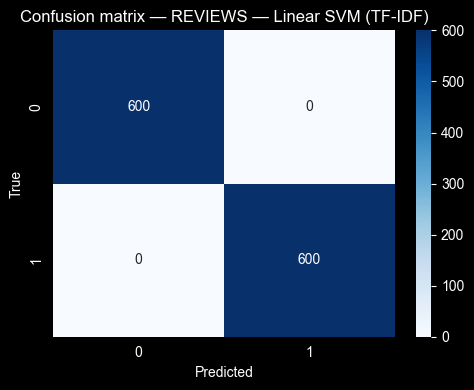

ROC-AUC:  1.0000 (decision_function)


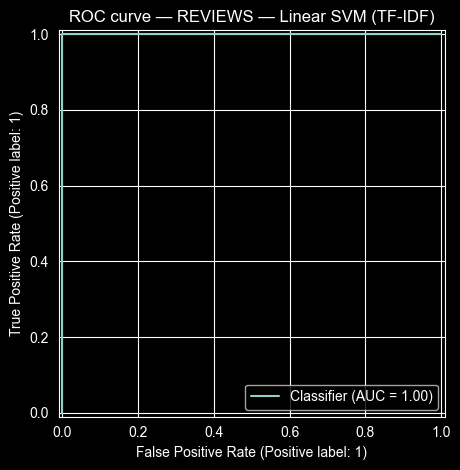


=== REVIEWS_REAL | Best model: Linear SVM (TF-IDF) ===
Accuracy: 0.8884
F1:       0.9015

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      6042
           1       0.89      0.92      0.90      7603

    accuracy                           0.89     13645
   macro avg       0.89      0.88      0.89     13645
weighted avg       0.89      0.89      0.89     13645



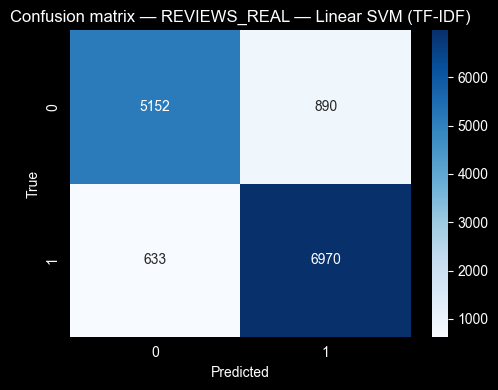

ROC-AUC:  0.9553 (decision_function)


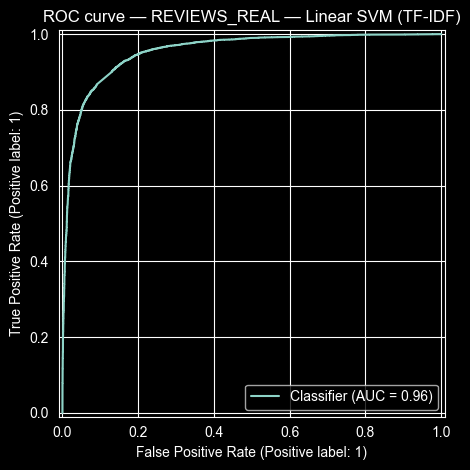

,accuracy,f1,roc_auc
REVIEWS,1.000000,1.000000,1.000000
REVIEWS_REAL,0.888384,0.901507,0.955304


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, RocCurveDisplay
)
from sklearn.model_selection import train_test_split

def evaluate_with_reports(model_name, pipe, X, y, test_size=0.2, label="DATASET"):
    # robimy ten sam split jak wcześniej, żeby było spójnie
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=RANDOM_STATE
    )

    m = clone(pipe)
    m.fit(X_tr, y_tr)

    pred = m.predict(X_te)

    acc = accuracy_score(y_te, pred)
    f1 = f1_score(y_te, pred)

    print(f"\n=== {label} | Best model: {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1:       {f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_te, pred, zero_division=0))

    cm = confusion_matrix(y_te, pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.title(f"Confusion matrix — {label} — {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # ROC-AUC (proba albo decision_function)
    roc_auc = None
    y_score = None

    if hasattr(m, "predict_proba"):
        y_score = m.predict_proba(X_te)[:, 1]
        roc_auc = roc_auc_score(y_te, y_score)
        print(f"ROC-AUC:  {roc_auc:.4f} (predict_proba)")
    else:
        try:
            y_score = m.decision_function(X_te)
            roc_auc = roc_auc_score(y_te, y_score)
            print(f"ROC-AUC:  {roc_auc:.4f} (decision_function)")
        except Exception:
            print("ROC-AUC:  n/a (no predict_proba/decision_function)")

    # wykres ROC jeśli mamy score
    if y_score is not None:
        RocCurveDisplay.from_predictions(y_te, y_score)
        plt.title(f"ROC curve — {label} — {model_name}")
        plt.tight_layout()
        plt.show()

    return {"accuracy": acc, "f1": f1, "roc_auc": roc_auc}

# 1) szczegółowo na REVIEWS
best_reviews = evaluate_with_reports(best_name, best_pipe, X_reviews, y_reviews, test_size=0.2, label="REVIEWS")

# 2) szczegółowo na REVIEWS_REAL
best_reviews_real = evaluate_with_reports(best_name, best_pipe, X_reviews_real, y_reviews_real, test_size=0.2, label="REVIEWS_REAL")

final_summary = pd.DataFrame(
    {"REVIEWS": best_reviews, "REVIEWS_REAL": best_reviews_real}
).T

display(final_summary)
